# practicalMixGauss_Apples

In [1]:
import glob
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

%matplotlib notebook
%matplotlib inline

%load_ext autoreload
%autoreload 2

**A)** Download and unzip the file apples.zip. Notice that for every color photo containing
apples, there is a corresponding binary image mask. In a mask image, white pixels indicate
locations where the corresponding photo is an apple. In floating point, you may need to
threshold to get binary values. Note that these mask images are inexact! While a perfect
ground-truth mask image’s black pixels should correspond to non-apples, these masks were
painted in a hurry, so the white areas were painted conservatively.

In [7]:
# Load image and corresponding mask data
trainfiles_apple = glob.glob("apples/*.jpg")
trainfiles_mask = glob.glob("apples/*.png")
testfiles_apple = glob.glob("testApples/*.jpg")
testfiles_mask = glob.glob("testApples/*.png")

ColorImgs_Train = []
ColorImgs_Train_Mask = []
ColorImgs_Test = []
ColorImgs_Test_Mask = []

for myFile in trainfiles_apple:
    im = plt.imread(myFile)
    im = im / 255.0
    ColorImgs_Train.append(im)

for myFile in trainfiles_mask:
    im = plt.imread(myFile)[:, :, 1]    # pick one channel arbitrary
    im = (im > 0.5).astype(np.uint8)    # convert to binary image
    ColorImgs_Train_Mask.append(im)

for myFile in testfiles_apple:
    im = plt.imread(myFile)
    im = im / 255.0
    ColorImgs_Test.append(im)

for myFile in testfiles_mask:
    im = plt.imread(myFile)[:, :, 1]    # pick one channel arbitrary
    im = (im > 0.5).astype(np.uint8)    # convert to binary image
    ColorImgs_Test_Mask.append(im)

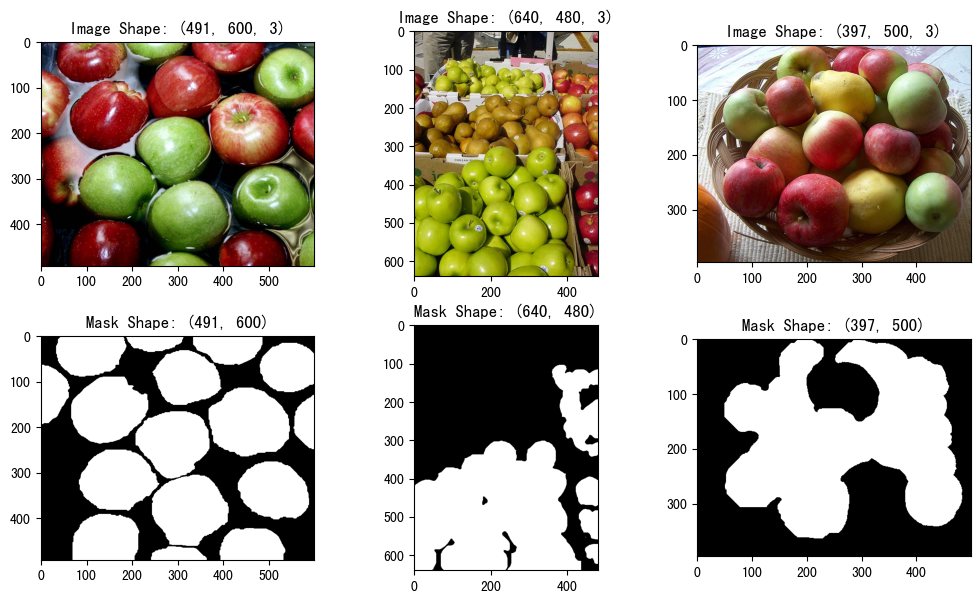

In [8]:
RGBNonApple = []
RGBApple = []

n = len(ColorImgs_Train)

fig, axs = plt.subplots(2, n, figsize=(4*n, 7))
for i in range(n):
    axs[0, i].imshow(ColorImgs_Train[i])
    axs[1, i].imshow(ColorImgs_Train_Mask[i], cmap='gray')
    axs[0, i].set_title(f"Image Shape: {ColorImgs_Train[i].shape}")
    axs[1, i].set_title(f"Mask Shape: {ColorImgs_Train_Mask[i].shape}")
    # axs[i, 0].axis('off')
    # axs[i, 1].axis('off')

    pixels_mask_0 = ColorImgs_Train[i][ColorImgs_Train_Mask[i]==0].transpose()
    pixels_mask_1 = ColorImgs_Train[i][ColorImgs_Train_Mask[i]==1].transpose()
    RGBNonApple.append(pixels_mask_0)
    RGBApple.append(pixels_mask_1)

RGBNonApple = np.concatenate(RGBNonApple, axis=1)
RGBApple = np.concatenate(RGBApple, axis=1)

plt.show()

**B)** Use mixtures of Gaussians to distinguish apple vs. non-apple pixels. Use red, green, and
blue as your dimensions for now. Make any other decisions you need to, and document them
in your .ipynb notebook.

In [4]:
# Define a multivariate normal probability density calculation function
def multivariate_normal_prob(data, mean, cov):
    
    # Use Cholesky decomposition to avoid compute inverse of cov directly, which will cause serious problem if nData is too large.
    if mean.ndim == 1:
        mean = mean[:, np.newaxis]
    # Cholesky decomposition
    cov_chol = np.linalg.cholesky(cov)
    cov_det = np.linalg.det(cov)
    
    diff = data - mean
    z = np.linalg.solve(cov_chol, diff)
    exponent = -0.5 * np.sum(z**2, axis=0)
    prob = (1.0 / ((2 * np.pi) ** (len(mean)/2) * cov_det ** 0.5)) * np.exp(exponent)

    return prob

<mark>Comments:<mark>

Use **Cholesky Decomposition** *(inspired by a piece of template code in practicalC)*.

At the beginning, there's no problem when looping over each data point to compute normal probability, the only thing is that the execution time lasting unbearable long on the whole dataset. Therefore, I opted for a **vectorized method** to reduce iterations and save operation time: Instead of computing normal probability for each data individually, I use multivariate normal probability equation on the entire dataset.

However, this change introduced the other serious problem: *the computation of inverse on large covariance matrix*. The computational complexity of this inverse process increased exponentially with the growing size of the dataset. (made my laptop crashed several times)

After some research, I utilize the property of **cholesky decomposition method** to compute the multivariate normal probability without directly calculating the inverse of covariance matrix, thereby addressing the computational challenges.

In [5]:
def calcMixGaussProb(data, mixGaussEst): 
    """
    Returns the likelihood that each data point in data belongs to the Mixture of Gaussian described by mixGaussEst.
    
    Keyword arguments:
    data -- d by n matrix containing data points.
    mixGaussEst -- dict containing the mixture of gaussians parameters.

    Returns: 
    like -- 1 by n vector contianing the likelihood that each data point in data belongs to the MixGaussian distribution.

    """
    
    data = np.atleast_2d(data)                                                                         
    # find total number of data items                                                                  
    nDims, nData = data.shape                                                                          
    
    like = np.zeros((1, nData))
    
    for k in range(mixGaussEst['k']):
        weight = mixGaussEst['weight'][k]
        mean = mixGaussEst['mean'][:, k]
        cov = mixGaussEst['cov'][:, :, k]
        prob = multivariate_normal_prob(data, mean, cov)   # (nData,)
        like += (weight * prob).reshape(1, -1)  # (1, nData)
                                                                                                
    return like                                                                       
                                                                                                       

In [6]:
def getMixGaussLogLike(data, mixGaussEst):
    """
    Calculate the log likelihood for the whole dataset under a mixture of Gaussians model.
    
    Keyword arguments:
    data -- d by n matrix containing data points.
    mixGaussEst -- dict containing the mixture of gaussians parameters.

    Returns: 
    logLike -- scalar containing the log likelihood.
    
    """
    
    data = np.atleast_2d(data)                                                                           
    
    # initialize log likelihoods                                                                       
    logLike = 0                                                                                   
                                                                     
    # calculate likelihood of this data point under mixture of Gaussians model. 
    like = 0                                                             
    for k in range(mixGaussEst['k']):
        weight = mixGaussEst['weight'][k]
        mean = mixGaussEst['mean'][:, k]
        cov = mixGaussEst['cov'][:, :, k]
        prob = multivariate_normal_prob(data, mean, cov)   # (nData, )
        like += weight*prob
                                                                   
    logLike = np.sum(np.log(like)) 

    return logLike


In [11]:
def fitMixGauss(data, k):
    """
    Estimate a k MoG model that would fit the data. Incremently plots the outcome.
               
    
    Keyword arguments:
    data -- d by n matrix containing data points.
    k -- scalar representing the number of gaussians to use in the MoG model.
    
    Returns: 
    mixGaussEst -- dict containing the estimated MoG parameters.
    
    """
    
    #     MAIN E-M ROUTINE  
    #     In the E-M algorithm, we calculate a complete posterior distribution over the (nData) hidden variables in the E-Step.  
    #     In the M-Step, we update the parameters of the Gaussians (mean, cov, w).   
    
    nDims, nData = data.shape

    postHidden = np.zeros(shape=(k, nData))

    # initialize the values
    mixGaussEst = dict()
    mixGaussEst['d'] = nDims
    mixGaussEst['k'] = k
    mixGaussEst['weight'] = (1 / k) * np.ones(shape=(k))
    # mixGaussEst['mean'] = 2 * np.random.randn(nDims, k)
    # the means to the values of K randomly chosen datapoints
    selected_columns = np.random.choice(data.shape[1], k, replace=False)
    mixGaussEst['mean'] = data[:, selected_columns]
    # set the variances to the variance of the whole dataset
    mixGaussEst['cov'] = np.zeros(shape=(nDims, nDims, k))
    for cGauss in range(k):
        # mixGaussEst['cov'][:, :, cGauss] = 2.5 + 1.5 * np.random.uniform() * np.eye(nDims)
        mixGaussEst['cov'][:, :, cGauss] = (data - mixGaussEst['mean'][:, [cGauss]]) @ (data - mixGaussEst['mean'][:, [cGauss]]).T / (nData - 1)


    # calculate current likelihood
    logLike = getMixGaussLogLike(data, mixGaussEst)
    print('Log Likelihood Iter 0 : {:4.3f}\n'.format(logLike))

    nIter = 30

    for cIter in range(nIter):

        # ===================== =====================
        # Expectation step
        # ===================== =====================
        
        for cGauss in range(k):
            mean = mixGaussEst['mean'][:, cGauss]
            cov = mixGaussEst['cov'][:, :, cGauss]
            weight = mixGaussEst['weight'][cGauss]
            prob = multivariate_normal_prob(data, mean, cov)
            postHidden[cGauss, :] = weight*prob
        postHidden /= np.sum(postHidden, axis=0)

        # ===================== =====================
        # Maximization Step
        # ===================== =====================
        # for each constituent Gaussian
        for cGauss in range(k):
            # Update weighting parameters mixGauss.weight based on the total posterior probability associated with each Gaussian.
            mixGaussEst['weight'][cGauss] = np.sum(postHidden[cGauss, :]) / np.sum(postHidden)
            
            
            # Update mean parameters mixGauss.mean by weighted average
            # where weights are given by posterior probability associated with Gaussian. 
            mixGaussEst['mean'][:,cGauss] = np.sum(postHidden[cGauss, :] * data, axis=1) / np.sum(postHidden[cGauss, :])
            
            
            # Update covarance parameter based on weighted average of square distance from update mean,
            # where weights are given by posterior probability associated with Gaussian
            mixGaussEst['cov'][:,:,cGauss] = (postHidden[cGauss, :] * (data - mixGaussEst['mean'][:,cGauss][:, np.newaxis]) @ (data - mixGaussEst['mean'][:,cGauss][:, np.newaxis]).T) / np.sum(postHidden[cGauss, :])
            # new_diagonal_values = np.diag((postHidden[cGauss, :] * (data - mixGaussEst['mean'][:,cGauss][:, np.newaxis]) @ (data - mixGaussEst['mean'][:,cGauss][:, np.newaxis]).T) / np.sum(postHidden[cGauss, :]))
            # mixGaussEst['cov'][:,:,cGauss] += np.diag(new_diagonal_values - np.diag(mixGaussEst['cov'][:,:,cGauss]))

        # calculate the log likelihood
        logLike = getMixGaussLogLike(data, mixGaussEst)
        print('Log Likelihood After Iter {} : {:4.3f}\n'.format(cIter, logLike))
        


    return mixGaussEst

In [75]:
# Define number of components to estimate
# Hyperparameters, can be modified based on the result of validation set
nGaussEst_Apple = 2
nGaussEst_NonApple = 3
# Fit mixture of Gaussian
mixGaussEst_Apple = fitMixGauss(RGBApple, nGaussEst_Apple)
mixGaussEst_NonApple = fitMixGauss(RGBNonApple, nGaussEst_NonApple)

Log Likelihood Iter 0 : 62171.477

Log Likelihood After Iter 0 : 321340.442

Log Likelihood After Iter 1 : 363578.072

Log Likelihood After Iter 2 : 403553.897

Log Likelihood After Iter 3 : 430154.376

Log Likelihood After Iter 4 : 442387.607

Log Likelihood After Iter 5 : 447092.387

Log Likelihood After Iter 6 : 450139.962

Log Likelihood After Iter 7 : 453385.317

Log Likelihood After Iter 8 : 456957.421

Log Likelihood After Iter 9 : 460367.442

Log Likelihood After Iter 10 : 463103.055

Log Likelihood After Iter 11 : 465071.604

Log Likelihood After Iter 12 : 466492.107

Log Likelihood After Iter 13 : 467595.839

Log Likelihood After Iter 14 : 468526.290

Log Likelihood After Iter 15 : 469357.432

Log Likelihood After Iter 16 : 470126.026

Log Likelihood After Iter 17 : 470850.798

Log Likelihood After Iter 18 : 471541.391

Log Likelihood After Iter 19 : 472202.750

Log Likelihood After Iter 20 : 472837.404

Log Likelihood After Iter 21 : 473446.718

Log Likelihood After Iter 22 

**C)** Download the file testApples.zip. Generate figures for your notebook, showing each
pixel’s posterior probability of being “apple.” Comment on the outcomes.

In [86]:
# Create a list to store prediction posterior probablities
posteriorApples = []

# Define priors for whether the pixel is apple or non apple
priorApple = 0.5
priorNonApple = 0.5
# Run through the pixels in the image on test set and classify them as being apple or non apple - we will fill in the posterior
for test_img in ColorImgs_Test:
    height, width, channel = test_img.shape
    posteriorApple = np.zeros([height,width])
    data_test = test_img.transpose(2, 0, 1).reshape(3, -1)

    likeApple = calcMixGaussProb(data_test, mixGaussEst_Apple)
    likeNonApple = calcMixGaussProb(data_test, mixGaussEst_NonApple)

    posteriorApple = likeApple*priorApple / (likeApple*priorApple + likeNonApple*priorNonApple)
    posteriorApple = posteriorApple.reshape(height, width)
    posteriorApples.append(posteriorApple)

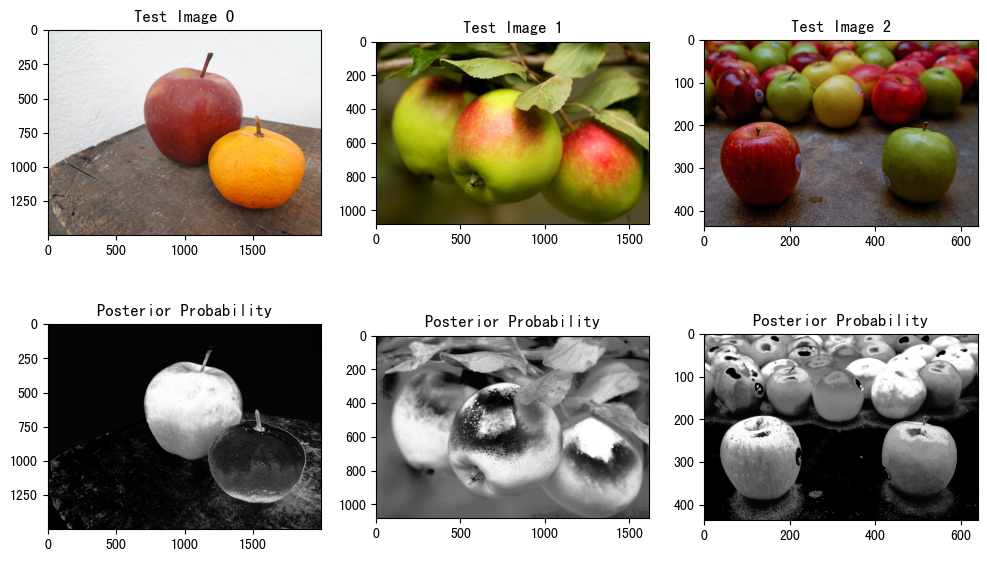

In [87]:
# Plot the results
n = len(ColorImgs_Test)
fig, axs = plt.subplots(2, n, figsize=(4*n, 7))
for i in range(n):
    axs[0, i].imshow(ColorImgs_Test[i])
    axs[0, i].set_title(f'Test Image {i}')
    axs[1, i].imshow(posteriorApples[i], cmap='gray')
    axs[1, i].set_title(f"Posterior Probability")
    # axs[i, 0].axis('off')
    # axs[i, 1].axis('off')
plt.show()

<mark>Comments:<mark>

The figure illustrates the posterior probability of pixels predicted as **Apple** on test set images. 

We can see that the fitted model gives high probability on pixels with red and green colour, low probability on pixels with orange, dark and bright colour etc. (I set number of hidden variables as 2 on apple class, 3 on non-apple class. Because after analysing on train set, the main colour of apple pixels are red and green.)

The result of first image is quite effective, that's because the colour of non-apple pixels are distinguishable with red & green.

The result of second image is not as expected, which gives high probs on leaves and low probs on shadows on the apple. This is because the model discriminate apple and non-apple pixels solely dependant on colours. Obviously, leaves often have similar colour with green apples and shadows have different color against usual apples.

Similarly, the result of thrid image gives low probs on specular highlights on the apple. What's more, it gives relatively lower probs on yellow apples.

Mean colour of each hidden gaussian distribution of each class are shown as below:

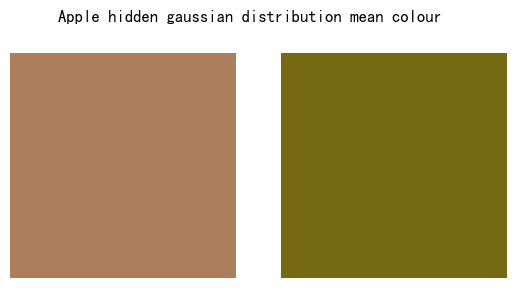

In [116]:
fig, axs = plt.subplots(1, nGaussEst_Apple)
fig.suptitle('Apple hidden gaussian distribution mean colour')
plt.subplots_adjust(top=1.2)
for k in range(nGaussEst_Apple):
    mean_colour = mixGaussEst_Apple['mean'][:, k]
    mean_colour_image = np.ones((5, 5))[:, :, np.newaxis] * mean_colour
    axs[k].imshow(mean_colour_image)
    axs[k].axis('off')
plt.show()

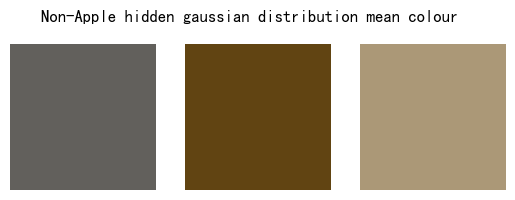

In [122]:
fig, axs = plt.subplots(1, nGaussEst_NonApple)
fig.suptitle('Non-Apple hidden gaussian distribution mean colour')
plt.subplots_adjust(top=1.4)
for k in range(nGaussEst_NonApple):
    mean_colour = mixGaussEst_NonApple['mean'][:, k]
    mean_colour_image = np.ones((5, 5))[:, :, np.newaxis] * mean_colour
    axs[k].imshow(mean_colour_image)
    axs[k].axis('off')
plt.show()

**D)** For the test image with a ground-truth mask, quantify and report your result. Hint:
consider applying a range of thresholds to the posterior to produce sets of {True Positives
(TP), True Negatives (TN), False Positives (FP), and False Negatives (FN)} and using an
ROC curve. Learn about ROC on Wikipedia or see Peter Flach’s chapter on the subject.

In [193]:
# functions to calculate tp, tn, fp, fn separatively
def true_positive(Y_test, y_pred):
    mask = (Y_test == 1)
    tp = (Y_test[mask] == y_pred[mask]).sum()
    return tp.item()

def true_negative(Y_test, y_pred):
    mask = (Y_test == 0)
    tn = (Y_test[mask] == y_pred[mask]).sum()
    return tn.item()

def false_negative(Y_test, y_pred):
    mask = (Y_test == 1)
    fn = (Y_test[mask] != y_pred[mask]).sum()
    return fn.item()

def false_positive(Y_test, y_pred):
    mask = (Y_test == 0)
    fp = (Y_test[mask] != y_pred[mask]).sum()
    return fp.item()

In [194]:
# calculate ROV curve
def calculate_roc_curve(Y_test, y_pred_proba, num_thresholds=100):
    thresholds = np.linspace(0, 1, num_thresholds)
    tpr_list = []
    fpr_list = []

    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(np.uint8)
        tp = true_positive(Y_test, y_pred)
        tn = true_negative(Y_test, y_pred)
        fp = false_positive(Y_test, y_pred)
        fn = false_negative(Y_test, y_pred)

        tpr = tp / (tp + fn)
        fpr = fp / (fp + tn)

        tpr_list.append(tpr)
        fpr_list.append(fpr)

    return fpr_list, tpr_list

# calculate AUC
def calculate_auc(fpr_list, tpr_list):
    auc_sum = 0
    sorted_fpr_list = sorted(fpr_list)
    sorted_tpr_list = sorted(tpr_list)
    for i in range(1, len(fpr_list)):
        auc_sum += 0.5 * (sorted_fpr_list[i] - sorted_fpr_list[i - 1]) * (sorted_tpr_list[i] + sorted_tpr_list[i - 1])

    return auc_sum

In [195]:
def plot_roc_curve(Y_test, y_pred_proba, num_thresholds=100):
    thresholds = np.linspace(0, 1, num_thresholds)
    fpr_list, tpr_list = calculate_roc_curve(Y_test, y_pred_proba, num_thresholds=100)
    auc = calculate_auc(fpr_list, tpr_list)

    distances = np.sqrt(np.array(fpr_list)**2 + (1 - np.array(tpr_list))**2)
    optimal_index = np.argmin(distances)

    plt.figure(figsize=(5, 5))
    plt.plot(fpr_list, tpr_list, color='darkorange', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.plot(fpr_list[optimal_index], tpr_list[optimal_index], marker='o', color='red', label='optimal threshold')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

    print('Optimal Threshold:', thresholds[optimal_index])
    print('Area Under the Curve (AUC):', auc)

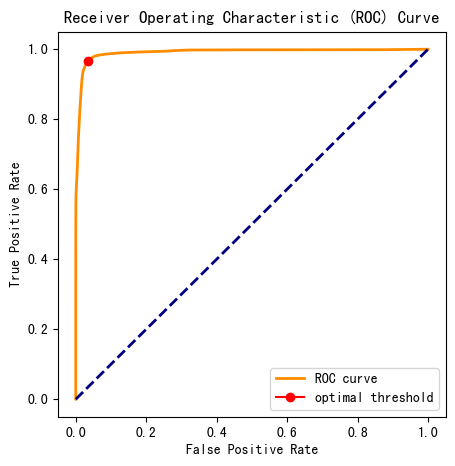

Optimal Threshold: 0.37373737373737376
Area Under the Curve (AUC): 0.991039846187775


In [196]:
# Define priors for whether the pixel is apple or non apple
priorApple = 0.5
priorNonApple = 0.5
 
# Run through the pixels in the image and classify them as being apple or non apple - we will fill in the posterior
# Test on test image with groundtruth
test_img = ColorImgs_Test[0]
gt = ColorImgs_Test_Mask[0]

height, width, channel = test_img.shape
posteriorApple = np.zeros([height,width])

data_test = test_img.transpose(2, 0, 1).reshape(3, -1)

likeApple = calcMixGaussProb(data_test, mixGaussEst_Apple)
likeNonApple = calcMixGaussProb(data_test, mixGaussEst_NonApple)

posteriorApple = likeApple*priorApple / (likeApple*priorApple + likeNonApple*priorNonApple)
posteriorApple = posteriorApple.reshape(height, width)

# Plot ROC curve for quantitative analysis
plot_roc_curve(gt, posteriorApple)

<mark>Comments:<mark>

ROC (receiver operating characteristic) curver characterize the performance of this binary classifier (apple v.s. non-apple).

When we change the threshold from 0 to 1, FPR and TPR change subsequently. The more pixels are correctly predicted as apple, the better the performance is. Therefore, we can get an optimal threshold value based on this curve. (the threshold that make point nearest to (0,1) coordinate)

Apart form that, we can use AUC (area under the curve) to evaluate the whole performance of the classifier. The bigger the auc is (the maximum is 1), the better the classifier is.

According to the above quantitative analysis, the AUC of my fitted mixGaussian classifier is 0.991 (really close to 1), which indicates a satisfactory performance. Besides, we can use the optimal threshold 0.37 to make predictions.

However, the performance analysis is solely based on a single test image, which may lead to bias and inaccuracy. As the prediction effect we tested on the whole test set are different, but the image we use to make quantitative analysis is the one with the best result.

Text(0.5, 1.0, 'Result (threshold=0.37)')

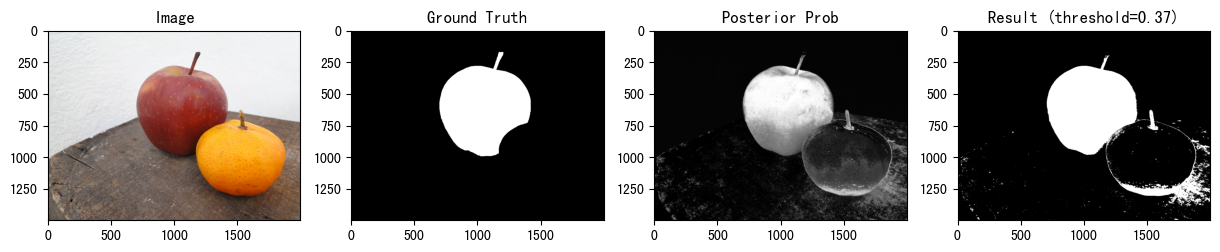

In [181]:
# Set threshold as optimum
threshold = 0.37
predictionApple = (posteriorApple > threshold).astype(np.uint8)

# set up plots.
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 5))
#show the image
ax1.imshow(test_img)
ax1.set_title('Image')
#show the ground truth mask
ax2.imshow(gt, cmap='gray')
ax2.set_title('Ground Truth')
#show prediction posterior probability
ax3.imshow(posteriorApple, cmap='gray')
ax3.set_title('Posterior Prob')
#show prediction label
ax4.imshow(predictionApple, cmap='gray')
ax4.set_title(f'Result (threshold={threshold})')

**E)** Download or snap two non-copyrighted photos with apples (maybe
http://search.creativecommons.org/ or some other source of images that are not copyrighted).
Make good ground-truth masks for them. You can use Windows Paint, or more sophisticated
programs like Gimp (free). Use these as extra test-images. Report your qualitative and
quantitative results.

In [303]:
# Load image and corresponding mask data
files_apple = glob.glob("myApples/*.jpg")
files_mask = glob.glob("myApples/*.png")

myApples = []
myApplesMask = []

for myFile in files_apple:
    im = plt.imread(myFile)
    im = im / 255.0
    myApples.append(im)

for myFile in files_mask:
    im = plt.imread(myFile)[:, :, 3]    # pick opaque channel
    im = (im > 0.5).astype(np.uint8)    # convert to binary image
    myApplesMask.append(im)

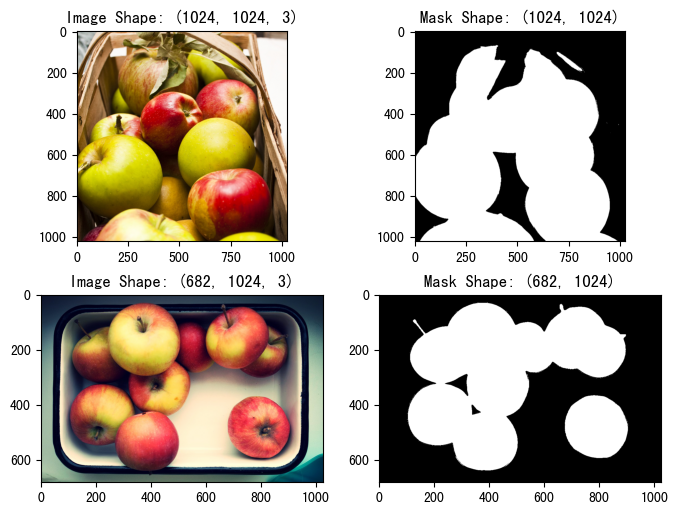

In [304]:
n = len(myApples)

fig, axs = plt.subplots(2, n, figsize=(8, 3*n))
for i in range(n):
    axs[i, 0].imshow(myApples[i])
    axs[i, 1].imshow(myApplesMask[i], cmap='gray')
    axs[i, 0].set_title(f"Image Shape: {myApples[i].shape}")
    axs[i, 1].set_title(f"Mask Shape: {myApplesMask[i].shape}")

plt.show()

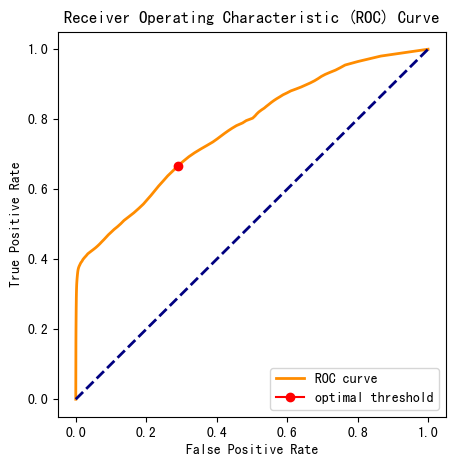

Optimal Threshold: 0.4444444444444445
Area Under the Curve (AUC): 0.7709085751131406


In [316]:
# Create a list to store prediction posterior probablities
posteriorApples = []
# Store all data information in the dataset together for quantitative analysis
all_posteriorApples = []
# Store all data's groundtruth together
gts = []
for mask in myApplesMask:
    gt = mask.reshape(1, mask.size)
    gts.append(gt)
gts = np.concatenate(gts, axis=1)

# Define priors for whether the pixel is apple or non apple
priorApple = 0.5
priorNonApple = 0.5
# Run through the pixels in the image on test set and classify them as being apple or non apple - we will fill in the posterior
for test_img in myApples:
    height, width, channel = test_img.shape
    posteriorApple = np.zeros([height,width])
    data_test = test_img.transpose(2, 0, 1).reshape(3, -1)

    likeApple = calcMixGaussProb(data_test, mixGaussEst_Apple)
    likeNonApple = calcMixGaussProb(data_test, mixGaussEst_NonApple)

    posteriorApple = likeApple*priorApple / (likeApple*priorApple + likeNonApple*priorNonApple)
    all_posteriorApples.append(posteriorApple)
    posteriorApple = posteriorApple.reshape(height, width)
    posteriorApples.append(posteriorApple)
    
all_posteriorApples = np.concatenate(all_posteriorApples, axis=1)

plot_roc_curve(gts, all_posteriorApples)

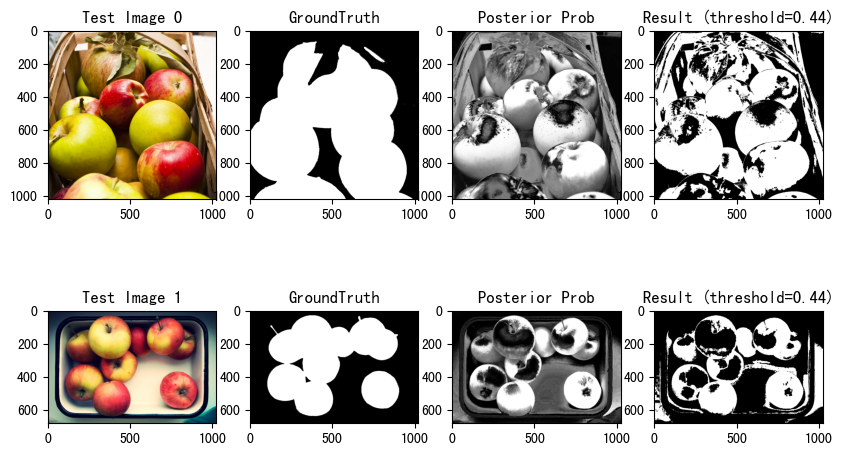

In [328]:
# Set threshold as optimum
threshold = 0.44
predictionApples = []
for posteriorApple in posteriorApples:
    predictionApples.append((posteriorApple > threshold).astype(np.uint8))

# Plot the results
n = len(myApples)
fig, axs = plt.subplots(n, 4, figsize=(10, 3*n))
for i in range(n):
    axs[i, 0].imshow(myApples[i])
    axs[i, 0].set_title(f'Test Image {i}')
    axs[i, 1].imshow(myApplesMask[i], cmap='gray')
    axs[i, 1].set_title(f"GroundTruth")
    axs[i, 2].imshow(posteriorApples[i], cmap='gray')
    axs[i, 2].set_title(f"Posterior Prob")
    axs[i, 3].imshow(predictionApples[i], cmap='gray')
    axs[i, 3].set_title(f"Result (threshold={threshold})")

plt.show()

<mark>Comments:<mark>

According to the experiment outcomes of the 2 test images (ROC curve, AUC, and intuitive visual perception), we can see that the classifier's performance is actually not quite satisfory. As I mentioned previously, the analysis on section D) merely based on a single image, which is inadequate and may lead to inaccuracy. This time we can notice an evident difference between the two test results.

The underlying reason for this disparity lies in the increased difficulty of distinguishing between apple and non-apple pixels based solely on pixel color this time. For example, the brown basket tend to be misclassified as apple, while bright immature-like colour on apple tend to be misclassified as non-apple.

Given the property of the classifier, it's really hard to generalize to diverse real-world scenarios with good performance.

Considering the graphical model we learned in week6, maybe it is a better solution to solve this task. Since graphical model will take relationship between neighbouring pixels into account. For example, the shadows or the specular highlights part on the apple would tend to be more likely predicted as apple pixels.

**F)** We should really be using three separate sets of files: a training set, a validation set, and a
test set! Explain why.

<mark>Comments:<mark>

Training set is used to fit model by adjusting parameters, enabling the model to capture potential distribution on this dataset. Test set is used to evaluate the performance of a model, especially to test generalization performance on brand-new data.

Apart from that, we can also make the use of validation set, which can help tuning hyperparameters (e.g. the number of hidden variables and iterations). In this experiment's context, we don't know exactly how many potential gaussian distribution have per class; we don't know how many times of iteration is appropriate. We can only set those values manually, and these parameters cannot be learned during training process. Nevertheless, with validation set, we can adjust it based on the performance on validation set. Therefore, validation set help us choice better hyperparameters and avoid overfitting or underfitting situations during training process.